<a href="https://colab.research.google.com/github/siontama/Data-Science/blob/master/vgg_flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필요한 라이브러리 import 시키기**

keras 사용?

In [2]:
from google.colab import drive

import tensorflow as tf # 일단은 import 시켜두자.

import numpy as np
import pandas as pd

import cv2
import scipy
from skimage import io

from PIL import ImageFile
from tqdm import tqdm

drive.mount('/content/gdrive')

tf.set_random_seed(777)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [4]:
from keras.preprocessing import image as keras_image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
10.149677326000017
GPU (s):
2.1578381360000094
GPU speedup over CPU: 4x


# 여러가지 함수 정의하기

In [0]:
# 손실 계산하는 함수
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  

# 정확도 측정하는 함수
def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy');
    
# 이미지 tensor로 바꿔주는 함수
# keras.processing의 내장 함수인 img_to_array() 함수를 이용하여 이미지들을 Tensor로 변환한다.
def path_to_tensor(img_path):
    # 자신의 드라이브에 맞는 경로를 넣는다.
    img = keras_image.load_img("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/"+img_path, 
                               target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

# 이미지 여러개 tensor들로 바꿔주는 함수
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data 시각화를 통해 조사해보기

In [0]:
flowers = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/flower_labels.csv") # 자신의 drive에 있는 데이터셋 경로(엑셀 파일)
flower_files = flowers['file']
flower_targets = flowers['label'].values

Label:  2


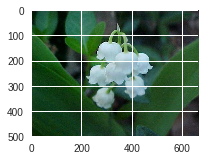

In [10]:
# 168번째 데이터가 어떤 것인지 확인해보자.

print('Label: ', flower_targets[168])
flower_image = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/flower/flowwe/"+flower_files[168])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

# Data를 Tensor로 변환

keras.processing의 내장 함수인 img_to_array() 함수를 이용하여 이미지들을 Tensor로 변환한다.

In [11]:
flower_tensors = paths_to_tensor(flower_files)

100%|██████████| 1360/1360 [11:27<00:00,  2.42it/s]


# 훈련 셋과 테스트 셋으로 나누기

In [12]:
# 전체 데이터 셋의 80퍼센트는 훈련 셋으로 나머지 20퍼센트는 테스트 셋으로 나누었다.
# 또한, 무작위로 훈련 셋과 테스트 셋을 뽑는 것이 학습에 도움이 되기에 무작위로 뽑았다.
x_train, x_test, y_train, y_test = train_test_split(flower_tensors, flower_targets, 
                                                    test_size = 0.2, random_state = 1)
print([x_train.shape, y_train.shape, x_test.shape, y_test.shape])

[(1088, 128, 128, 3), (1088,), (272, 128, 128, 3), (272,)]


# 테스트 셋에서 검증 셋으로 나누기

테스트 셋의 절반을 검증 셋으로 다시 나누어 주었다.

In [13]:
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]
print(x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape)

(1088, 128, 128, 3) (136, 128, 128, 3) (136, 128, 128, 3) (1088,) (136,) (136,)


Label:  0


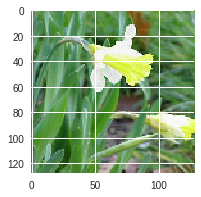

In [14]:
# 훈련 셋의 1번 데이터가 무엇인지 살펴보자.

print('Label: ', y_train[1])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]/255).reshape(128,128,3));

# 데이터 처리하기

In [15]:
# 데이터 형태 지정하기
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_valid = x_valid.astype('float32')/255

# 클래스 벡터(정수들)를 바이너리 클래스 매트릭스로 변환한다고 함.
c_y_train = to_categorical(y_train, 17)
c_y_test = to_categorical(y_test, 17)
c_y_valid = to_categorical(y_valid, 17)

print([x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape, x_valid.shape, c_y_valid.shape])

[(1088, 128, 128, 3), (1088, 17), (136, 128, 128, 3), (136, 17), (136, 128, 128, 3), (136, 17)]


# 모델 만들기

일단, CNN으로 안 하고 다른 모델을 가지고 한 번 해보는거 같음.

In [16]:
# 다층 퍼셉트론으로 만든 신경망임(mlp 신경망)
'''
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(192*192*3,)))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))     
    model.add(Dense(17, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()
'''

"\ndef mlp_mc_model():\n    model = Sequential()\n    \n    model.add(Dense(128, activation='relu', input_shape=(192*192*3,)))\n    model.add(BatchNormalization())\n    \n    model.add(Dense(256, activation='relu'))\n    model.add(BatchNormalization()) \n    \n    model.add(Dense(512, activation='relu'))\n    model.add(BatchNormalization())\n    \n    model.add(Dense(1024, activation='relu'))\n    model.add(Dropout(0.2))     \n    model.add(Dense(17, activation='softmax'))\n\n    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\n    return model\n\nmlp_mc_model = mlp_mc_model()\n"

# 모델 학습시키기

주의할 점은 테스트 셋은 맨 마지막을 위해 남겨두고 훈련셋으로 학습을 시키고 그 학습된 모델의 평가는 검증 셋으로 한다.

테스트 셋은 나중에 검증 셋으로 평가된 모델 중에 가장 일반화가 잘 된 모델이 무엇인지 확인하기 위해 사용할 것이다.

In [17]:
'''
mlp_mc_history = mlp_mc_model.fit(x_train.reshape(-1, 192*192*3), c_y_train,
                                  validation_data=(x_valid.reshape(-1, 192*192*3), c_y_valid),
                                  epochs=50, batch_size=64, verbose=2)
                                  '''

'\nmlp_mc_history = mlp_mc_model.fit(x_train.reshape(-1, 192*192*3), c_y_train,\n                                  validation_data=(x_valid.reshape(-1, 192*192*3), c_y_valid),\n                                  epochs=50, batch_size=64, verbose=2)\n                                  '

In [18]:
# 학습이 잘 진행되고 있는지 알아보기 위해 시각화시켜
# 훈련 셋과 검증 셋에 대한
# 손실과 정확도를 따져보도록 하자.

'''
loss_plot(mlp_mc_history)
acc_plot(mlp_mc_history)'''

'\nloss_plot(mlp_mc_history)\nacc_plot(mlp_mc_history)'

위의 그래프를 보면 알 수 있듯이

epoch(전체 데이터를 한 번 학습 시키는 것을 한 번 epoch했다고 한다.)가 늘어날수록 train셋에 대한 손실은 낮아지고 정확도는 올라가고 있음을 알 수 있다.

또한, test셋(여기서는 아직까지 검증 셋임.)에 대해서도 손실은 줄어들고 정확도는 올라가고 있음을 알 수 있다.

# Test 셋을 이용한 모델 정확도 평가

In [19]:
'''
mlp_mc_test_score = mlp_mc_model.evaluate(x_test.reshape(-1, 192*192*3), c_y_test)
print(mlp_mc_test_score)'''

'\nmlp_mc_test_score = mlp_mc_model.evaluate(x_test.reshape(-1, 192*192*3), c_y_test)\nprint(mlp_mc_test_score)'

# 모델 변경 : CNN

이전의 모델로 학습시켰을 때는 정확도가 낮게 나왔다.
따라서, 이전 모델 보다 나은 모델인 CNN을 만들어 학습시켜보자.

In [20]:
# 함수로 CNN을 정의하자.

# CNN
def cnn_mc_model():
    model = Sequential()

    # Convolution
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.25))
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(17))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# CNN으로 만든 모델에 학습 시키기

In [21]:
# CNN에 학습시키기

cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=50, batch_size=128, verbose=2,
                                  validation_data=(x_valid, c_y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 1088 samples, validate on 136 samples
Epoch 1/50
 - 5s - loss: 2.8326 - acc: 0.0561 - val_loss: 2.8871 - val_acc: 0.0735
Epoch 2/50
 - 2s - loss: 2.6871 - acc: 0.0864 - val_loss: 2.5047 - val_acc: 0.1103
Epoch 3/50
 - 2s - loss: 2.5652 - acc: 0.1140 - val_loss: 2.4357 - val_acc: 0.1324
Epoch 4/50
 - 2s - loss: 2.4550 - acc: 0.1618 - val_loss: 5.8634 - val_acc: 0.0662
Epoch 5/50
 - 2s - loss: 2.8343 - acc: 0.1452 - val_loss: 2.5329 - val_acc: 0.1324
Epoch 6/50
 - 2s - loss: 2.3960 - acc: 0.1756 - val_loss: 2.4743 - val_acc: 0.1176
Epoch 7/50
 - 2s - loss: 2.3832 - acc: 0.1801 - val_loss: 2.2144 - val_acc: 0.2574
Epoch 8/50
 - 2s - loss: 2.2265 - acc: 0.2243 - val_loss: 2.3176 - val_acc: 0.1691
Epoch 9/50
 - 2s - loss: 2.2506 - acc: 0.2390 - val_loss: 2.0908 - val_acc: 0.2647
Epoch 10/50
 - 2s - loss: 2.2506 - acc: 0.2261 - val_loss: 2.0077 - val_acc: 0.3088
Epoch 11/50
 - 2s - loss: 2.0348 - acc: 0.3088 - val_loss: 2.0377 - val_ac

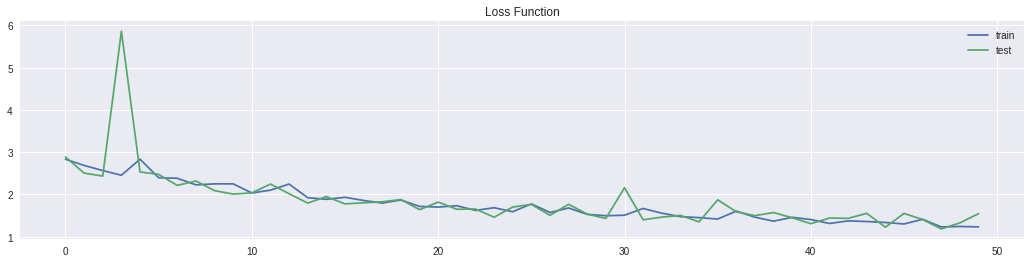

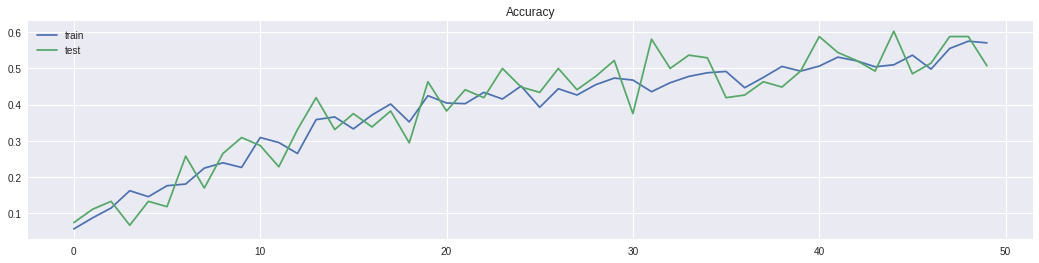

In [22]:
# 손실과 정확도를 마찬가지로 따져보자.

loss_plot(cnn_mc_history)
acc_plot(cnn_mc_history)

# Test 셋을 이용한 모델 정확도 평가

In [23]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
print(cnn_mc_test_score)

136/136 [==============================] - 0s 2ms/step
[1.61488877324497, 0.4632352941176471]


In [24]:
# 이건 뭐지??? => 약간 매개변수 조정하고 한듯..(최적화 단계?)

data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)
cnn_mc_dg_history = cnn_mc_model.fit_generator(data_generator.flow(x_train, c_y_train, batch_size=64),
                                               steps_per_epoch=189, epochs=3, verbose=2, 
                                               validation_data=(x_valid, c_y_valid))

Epoch 1/3
 - 52s - loss: 1.3055 - acc: 0.5417 - val_loss: 1.1491 - val_acc: 0.6324
Epoch 2/3
 - 52s - loss: 1.1398 - acc: 0.5996 - val_loss: 1.1647 - val_acc: 0.6176
Epoch 3/3
 - 52s - loss: 1.0054 - acc: 0.6461 - val_loss: 0.9398 - val_acc: 0.6838


In [25]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
print(cnn_mc_test_score)

136/136 [==============================] - 0s 716us/step
[1.0071052523220287, 0.6691176470588235]
